In [63]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dx #explainer for our model
from sklearn.metrics import mean_squared_error, r2_score

#sklearn 
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# XGB
#import xgboost as xgb
#from xgboost import XGBClassifier
#xgb.set_config(verbosity=0) # to supress warnings

# shap
import shap

#joblib to save trained models
import joblib

# Show pipelines as interactive diagram
from sklearn import set_config; set_config(display='diagram')

In [34]:
# Set random seed for reproducibility reasons
np.random.seed(42)

In [35]:
import sklearn, matplotlib
print("Installed/ Used versions:")
print("python: 3.8.6")
print("sklearn:", sklearn.__version__)
print("shap:", shap.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("joblib:", joblib.__version__)


Installed/ Used versions:
python: 3.8.6
sklearn: 1.0.2
shap: 0.40.0
numpy: 1.19.5
pandas: 1.2.4
matplotlib: 3.3.4
seaborn: 0.11.1
joblib: 1.0.1


# Importing the Clean Dataset

In [36]:
url = 'https://github.com/Heity94/Compas-recidivism-analysis/blob/master/data-cleaned/compas-scores-two-years-clean.csv?raw=true'
df = pd.read_csv(url, parse_dates=["c_jail_in", "c_jail_out"])
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,Risk of Violence,1,Low,2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,Risk of Violence,3,Low,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,High,Risk of Violence,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,Risk of Violence,1,Low,NaN,NaN,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,High,Risk of Violence,9,High,2014-04-07,2014-04-27,0,169,0,0
6212,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,Medium,Risk of Violence,5,Medium,2013-11-22,2013-11-24,1,860,0,0
6213,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,Low,Risk of Violence,5,Medium,2014-01-31,2014-02-02,1,790,0,0
6214,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-01-13,2014-01-14,0,808,0,0


# Feature Engineering: Create feature c_charge_degree_detailed

In [37]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df[df["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df[df["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))


Unique charges in the dataset: 408
Unique charges for felonies: 295
Unique charges for misdemeanors: 149


* In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
* The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
* We first used these crimes and mapped them against the current charges

# Map charge degree to all cases and store in new feature column c_charge_degree_detailed

In [38]:
# Load master lookup table
labeled_charges_master = pd.read_csv("../../notebooks/Philipp/labeled_charges_master.csv", index_col="c_charge_desc")

In [39]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df= df.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='c_charge_degree_detailed', ylabel='count'>

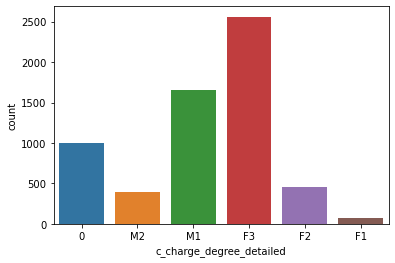

In [40]:
sns.countplot(x="c_charge_degree_detailed", data=df, order=["0","M2", "M1", "F3", "F2", "F1"])

In [41]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df[df.c_charge_degree_detailed.isnull()]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid,c_charge_degree_detailed
9,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less than 25,Caucasian,...,Risk of Violence,5,Medium,2015-01-06,2015-01-07,0,428,1,1,NaN
54,95,daquan davis,daquan,davis,2013-03-14,Male,1994-04-11,22,Less than 25,African-American,...,Risk of Violence,9,High,2013-05-23,2013-09-24,0,70,0,1,NaN
80,147,phillip bishop,phillip,bishop,2013-11-06,Male,1949-05-04,66,Greater than 45,Caucasian,...,Risk of Violence,1,Low,2013-09-03,2013-10-03,0,877,0,0,NaN
133,243,bryan sandrin,bryan,sandrin,2014-02-11,Male,1976-06-30,39,25 - 45,Caucasian,...,Risk of Violence,4,Low,2014-02-10,2014-02-14,3,780,0,0,NaN
160,285,charmaine ramkhelawan,charmaine,ramkhelawan,2013-07-22,Female,1964-04-16,52,Greater than 45,Other,...,Risk of Violence,1,Low,NaN,NaN,0,449,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5738,10143,joshua staley,joshua,staley,2013-05-14,Male,1989-09-14,26,25 - 45,African-American,...,Risk of Violence,5,Medium,2013-06-14,2013-06-25,0,31,0,0,NaN
6005,10588,sergio santibanez-cruz,sergio,santibanez-cruz,2013-03-13,Male,1990-09-08,25,25 - 45,Hispanic,...,Risk of Violence,3,Low,2013-01-29,2013-02-01,0,1115,0,0,NaN
6016,10611,edward eggers,edward,eggers,2013-10-24,Male,1961-05-01,54,Greater than 45,Caucasian,...,Risk of Violence,1,Low,2014-06-11,2014-07-18,0,101,1,1,NaN
6022,10624,marion davis,marion,davis,2013-02-07,Male,1988-02-26,28,25 - 45,African-American,...,Risk of Violence,3,Low,2013-02-07,2013-02-07,0,173,1,1,NaN


In [42]:
index_nan_cases = df[df.c_charge_degree_detailed.isnull()].index

# Descriptive Statistics

In [43]:
df['race'].value_counts()

African-American    3139
Caucasian           2132
Hispanic             563
Other                340
Asian                 28
Native American       14
Name: race, dtype: int64

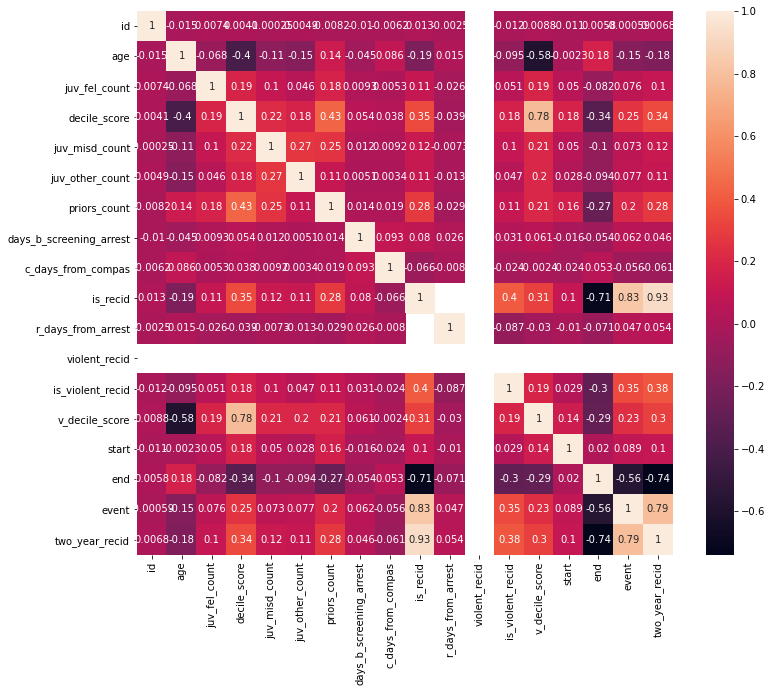

In [44]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True);

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

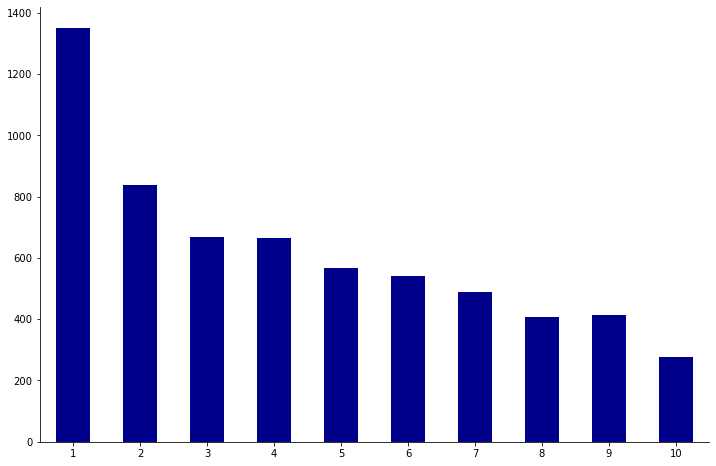

In [45]:
def create_groupcount_barplot(df, group_col, figsize, **kwargs):
    "call df.groupby(group_col), then count number of records and plot"
    counts = df.groupby(group_col)["name"].count().sort_index()

    fig, ax = plt.subplots(figsize=figsize)
    counts.plot(kind="bar", **kwargs)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig, ax

create_groupcount_barplot(df, "decile_score", (12, 8), color="DarkBlue", rot=0)

# We can already observe that that our target variable is not normally distributed. Therefore, we will proceed with the log of decile score.

In [46]:
df['decile_score_log'] = np.log(df.decile_score)

In [47]:
print(df.decile_score.skew())
print(df.decile_score_log.skew())

0.44499634284609496
-0.34657083633759855


* If skewness is between -0.5 and 0.5, the distribution is approximately symmetric. We have around -0.35.

In [48]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target= df.decile_score_log

# Feature Scaling

In [49]:
minmax_scaler = MinMaxScaler()
features_scaled = minmax_scaler.fit_transform(features)

In [50]:
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled['decile_score'] = np.log(df.decile_score)
df_scaled.head()

,age,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,degree_M,degree_desc_F1,degree_desc_F2,degree_desc_F3,degree_desc_M1,degree_desc_M2,priors_count,juv_fel_count,juv_misd_count,juv_other_count,two_year_recid,decile_score
0,0.649351,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,0.194805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,1.098612
2,0.064935,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.108108,0.0,0.000000,0.058824,1.0,1.386294
3,0.051948,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.027027,0.0,0.076923,0.000000,0.0,2.079442
4,0.311688,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,0.000000,0.000000,0.0,0.000000


# Linear Regression

In [51]:
features_scaled = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "degree_desc_F1",
                    "degree_desc_F2",
                    "degree_desc_F3",
                    "degree_desc_M1",
                    "degree_desc_F2",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_log= df_scaled.decile_score

In [52]:
x = features_scaled.values
y=target_log.values
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33)

In [53]:
linearreg = LinearRegression()
linearreg.fit(X_train,y_train)
y_pred = linearreg.predict(X_test)

In [55]:
exp_linearreg = dx.Explainer(linearreg, X_test, y_test, verbose=False)
exp_linearreg.model_performance().result


X has feature names, but LinearRegression was fitted without feature names
X has feature names, but LinearRegression was fitted without feature names


,mse,rmse,r2,mae,mad
LinearRegression,0.331507,0.575766,0.472003,0.470118,0.416097


# Polynomial Feautures

* The best degree of polynomial should be the degree that generates the lowest RMSE in cross validation set. 

In [56]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "degree_desc_F1",
                    "degree_desc_F2",
                    "degree_desc_F3",
                    "degree_desc_M1",
                    "degree_desc_F2",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df_scaled.decile_score

In [57]:
x_new = features_scaled.values
y_new=target_log.values
X_train, X_test, y_train, y_test = train_test_split(x_new,y_new, test_size=0.33)

Best degree 2 with RMSE 0.5455804664498447


Text(0, 0.5, 'RMSE')

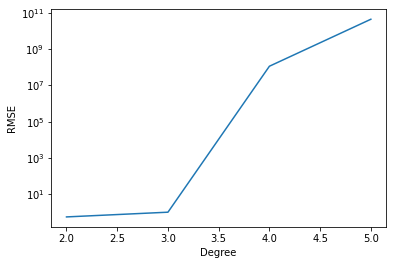

In [64]:
rmses = []
degrees = np.arange(2, 6)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(X_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(X_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

In [65]:
degree=2
polyreg_scaled=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg_scaled.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [70]:
exp_polynomial = dx.Explainer(linearreg, X_test, y_test, verbose=False)
exp_polynomial.model_performance().result


X has feature names, but LinearRegression was fitted without feature names
X has feature names, but LinearRegression was fitted without feature names


,mse,rmse,r2,mae,mad
LinearRegression,0.315463,0.561661,0.473325,0.457762,0.389981


# Lasso Regression

In [72]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "degree_desc_F1",
                    "degree_desc_F2",
                    "degree_desc_F3",
                    "degree_desc_M1",
                    "degree_desc_F2",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df_scaled["decile_score"]

In [73]:
x = features_new
y=target_log.values
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33)


In [74]:
#optimal parameter

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha':np.arange(0.1,1,0.05)}

lasso = Lasso()

lasso_cv = GridSearchCV(lasso, param_grid, cv = 5)

lasso_cv.fit(X_train, y_train)
print(lasso_cv.best_params_)

print('Training Score:', lasso_cv.score(X_train, y_train))
print('Test Score:', lasso_cv.score(X_test, y_test))

{'alpha': 0.1}
Training Score: 0.03979770006099248
Test Score: 0.03911454146654958


In [80]:
lasso = Lasso(alpha=0.1) #, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
#Returns the coefficient of determination R^2 of the prediction.
lasso.score(X_test, y_test)
r2_score(y_test, lasso_pred)

0.03911454146654958

In [78]:
exp_lasso = dx.Explainer(lasso, X_test, y_test, verbose=False)
exp_lasso.model_performance().result

X does not have valid feature names, but Lasso was fitted with feature names


,mse,rmse,r2,mae,mad
Lasso,0.583276,0.763725,0.039115,0.661519,0.633599


In [82]:
mean_squared_error(y_test, y_pred, squared=False)

0.9499069632531411

# Ridge Regression

In [56]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "degree_desc_F1",
                    "degree_desc_F2",
                    "degree_desc_F3",
                    "degree_desc_M1",
                    "degree_desc_F2",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df_scaled.decile_score

In [57]:
X = features_scaled.values
y=target_new.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

In [58]:
model = Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.460 (0.012)


In [63]:
model = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.459
Config: {'alpha': 0.01}


In [59]:
ridge2 = Ridge(alpha=0.1, normalize=False)
ridge2.fit(X_train, y_train)
ridge2_pred = ridge2.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [60]:
r2_score(y_test, ridge2_pred)

0.47187334275456794

In [61]:
mean_squared_error(y_test, ridge2_pred)

0.3263262934963612

In [62]:
mean_squared_error(y_test, y_pred, squared=False)

0.9591754831028093

# Elastic Net

In [64]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "degree_desc_F1",
                    "degree_desc_F2",
                    "degree_desc_F3",
                    "degree_desc_M1",
                    "degree_desc_F2",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df_scaled.decile_score

In [65]:
X = features_scaled.values
y=target_new.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

In [66]:
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.681 (0.013)


In [67]:
ElasticNet = ElasticNet(alpha=0.1, normalize=False)
ElasticNet.fit(X_train, y_train)
ElasticNet_pred = ElasticNet.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [68]:
r2_score(y_test, ElasticNet_pred)

0.10426268165535335

In [69]:
mean_squared_error(y_test, ElasticNet_pred)

0.5489019990426349

In [70]:
mean_squared_error(y_test, y_pred, squared=False)

0.9529632717153206

# Random Forest 

In [74]:
#Import required libraries
from sklearn.ensemble import RandomForestRegressor

In [75]:
#Define the variables considered to implement the model 
X = features_new
y = df_scaled.decile_score

In [76]:
#Divide the data in training and test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)

In [77]:
#Create the model Random forest and the estimators number 
RF_model = RandomForestRegressor(n_estimators = 100,
                                 random_state = 0,
                                bootstrap = True)
                                

In [78]:
#Fit the model with the training data 
RF_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [79]:
y_predict_rfr = RF_model.predict(X_test)

In [80]:
from sklearn import metrics
r_square_regressor = metrics.r2_score(y_test, y_predict_rfr)
print("R-Square Error Associated with Random forest regressor is : ", r_square_regressor)

R-Square Error Associated with Random forest regressor is :  0.3974586928260163


In [81]:
#Accuracy of the model 
RF_model.score(X_test, y_test)

0.3974586928260163

In [82]:
mean_squared_error(y_test, y_predict_rfr)

0.36808597895981265

In [83]:
mean_squared_error(y_test, y_predict_rfr, squared=False)

0.6067008974443772